# Build a basic chatbot

Install the prereuisit requirements

``` 
pip install -U langgraph
```


- `from typing import Annotated` and `from typing_extensions import TypedDict`:  
    These are used for type annotations. `TypedDict` lets you define a dictionary with specific keys and value types. `Annotated` allows you to add metadata to types.

- `from langgraph.graph import StateGraph, START` and `from langgraph.graph.message import add_messages`:  
    These import classes and functions from the `langgraph` library, which is used for building conversational AI workflows.

- `class State(TypedDict): ...`:  
    This defines a dictionary type called `State` with a single key, `messages`, which is a list. The `add_messages` annotation specifies that when updating this key, new messages should be appended to the list rather than replacing it.

- `graph_builder = StateGraph(State)`:  
    This creates a new state graph for managing the chatbot’s conversation state, using the `State` structure defined above.

In summary, this code sets up the data structure and graph logic needed to build a chatbot that tracks a list of messages in its state.

### Define StateGraph

In [23]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
load_dotenv()


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

### Define LLM

In [24]:
from langchain_groq import ChatGroq 
import os
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
llm = ChatGroq(temperature=0,
                    model_name="llama-3.3-70b-versatile",
                    api_key= GROQ_API_KEY
                   )


### Make Node

In [25]:
def chatbot(state: State):
    response = llm.invoke(state["messages"])

    return {"messages": [response]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [26]:
graph_builder.add_edge(START, "chatbot")

In [27]:
graph = graph_builder.compile()

### Display Graph

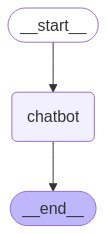

In [28]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Query to graph

In [29]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        # stream_graph_updates(user_input)
        print(graph.invoke({"messages": [{"role": "user", "content": user_input}]}))
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Goodbye!


# Add tools

```bash
pip install -U langchain-tavily

### Init tool

In [30]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=1)

tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': "Introduction to LangGraph: A Beginner's Guide - Medium",
   'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
   'content': 'Stateful Graph: LangGraph revolves around the concept of a stateful graph, where each node in the graph represents a step in your computation, and the graph maintains a state that is passed around and updated as the computation progresses. LangGraph supports conditional edges, allowing you to dynamically determine the next node to execute based on the current state of the graph. We define nodes for classifying the input, handling greetings, and handling search queries. def classify_input_node(state): LangGraph is a versatile tool for building complex, stateful applications with LLMs. By understanding its core concepts and working through simple examples, beginners can start to leverage its powe

### Init LLM

In [31]:
from langchain_groq import ChatGroq 
import os
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
llm = ChatGroq(temperature=0,
                    model_name="llama-3.3-70b-versatile",
                    api_key= GROQ_API_KEY
                   )


### Define the graph

In [32]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
# highlight-next-line
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

### Create a function to run the tools

In [33]:
import json

from langchain_core.messages import ToolMessage, HumanMessage, AIMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

### Crear Router Function

In [34]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

### Dispaly the graph

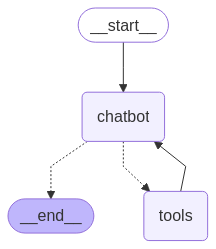

In [35]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Query to graph with tools

In [36]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Goodbye!


### Toos Call using prebuild function

In [37]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

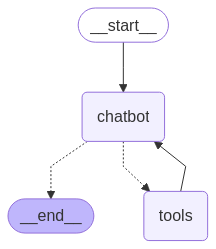

In [38]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Add memory

### Create a MemorySaver checkpointer

In [39]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

### Compile the graph with checkpointer

In [40]:
graph = graph_builder.compile(checkpointer=memory)

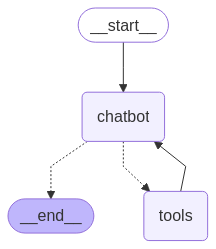

In [41]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Interact with chatbot

In [42]:
#Pick a thread to use as the key for this conversation.
config = {"configurable": {"thread_id": "1"}}

In [43]:
# call the chatbot
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    # event["messages"][-1].pretty_print()
    print("Assistant:", event["messages"][-1].content)

Assistant: Hi there! My name is Will.
Assistant: It's nice to meet you, Will. Is there something I can help you with or would you like to chat?


In [44]:
#Ask a follow up question
user_input = "Todays, weather?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()
    # print(event['messages'])

================================ Human Message =================================

Todays, weather?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_e3ke)
 Call ID: call_e3ke
  Args:
    query: today's weather
    search_depth: basic
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "today's weather", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Weather in current location", "url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Current', 'region': 'Harbour Island', 'country': 'Bahamas', 'lat': 25.4333, 'lon': -76.7833, 'tz_id': 'America/Nassau', 'localtime_epoch': 1748674472, 'localtime': '2025-05-31 02:54'}, 'current': {'last_updated_epoch': 1748673900, 'last_updated': '2025-05-31 02:45', 'temp_c': 26.3, 'temp_f': 79.3, 'is_day': 0, 'condition': {'text': 'Partly Cloudy', 'icon': '//cdn.

### Inspect the state

In [45]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='2a1da4ab-7de2-4adb-9eba-520179c9425d'), AIMessage(content="It's nice to meet you, Will. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 1187, 'total_tokens': 1212, 'completion_time': 0.090909091, 'prompt_time': 0.08391044, 'queue_time': 0.24044699900000002, 'total_time': 0.174819531}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'finish_reason': 'stop', 'logprobs': None}, id='run--1e122b4a-8e89-48d0-9012-b58c521d8c09-0', usage_metadata={'input_tokens': 1187, 'output_tokens': 25, 'total_tokens': 1212}), HumanMessage(content='Todays, weather?', additional_kwargs={}, response_metadata={}, id='dad07377-7b29-4bda-8ac0-50ad7f5907fd'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_e3ke',

# Add human-in-the-loop controls

### Add the human_assistance tool

In [46]:
from langgraph.types import Command, interrupt
from langchain_core.tools import tool

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]


In [47]:
from typing import Annotated

from langchain_tavily import TavilySearch

from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

from langchain_groq import ChatGroq 
import os
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
llm = ChatGroq(temperature=0,
                    model_name="llama-3.3-70b-versatile",
                    api_key= GROQ_API_KEY
                   )

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

### Compile the graph

In [48]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

### Visualize the graph (optional)

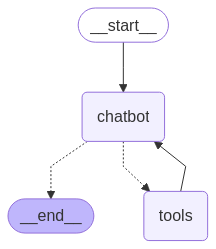

In [49]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Prompt the chatbot

In [50]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_r4vg)
 Call ID: call_r4vg
  Args:
    query: building an AI agent guidance and support


In [51]:
snapshot = graph.get_state(config)
print(snapshot)
snapshot.next

StateSnapshot(values={'messages': [HumanMessage(content='I need some expert guidance for building an AI agent. Could you request assistance for me?', additional_kwargs={}, response_metadata={}, id='b048c5c6-c14f-4efd-bc3f-efb88c1834a1'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_r4vg', 'function': {'arguments': '{"query":"building an AI agent guidance and support"}', 'name': 'human_assistance'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 1248, 'total_tokens': 1270, 'completion_time': 0.08, 'prompt_time': 0.087527639, 'queue_time': 0.244724463, 'total_time': 0.167527639}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0aedd3b3-362c-4c0a-8ac7-565f009e3a37-0', tool_calls=[{'name': 'human_assistance', 'args': {'query': 'building an AI agent guidance and support'}, 'id': 'call_r4vg', 'type': 'tool_call'}], usage_metad

('tools',)

### Resume execution

In [52]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_r4vg)
 Call ID: call_r4vg
  Args:
    query: building an AI agent guidance and support
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

I hope the expert guidance helps you build your AI agent. If you have any more questions or need further assistance, feel free to ask.


# Customize state

### Add keys to the state

In [53]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

###  Update the state inside the tool

In [54]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt

@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

In [55]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt

from langchain_groq import ChatGroq 
import os
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
llm = ChatGroq(temperature=0,
                    model_name="llama-3.3-70b-versatile",
                    api_key= GROQ_API_KEY
                   )

class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

@tool
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    return Command(update=state_update)


tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # assert(len(message.tool_calls) <= 1)
    return {"messages": [message]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

### Prompt the chatbot

In [56]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer from search tool, then use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "3"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer from search tool, then use the human_assistance tool for review.
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_c05m)
 Call ID: call_c05m
  Args:
    query: LangGraph release date
    search_depth: advanced
    topic: general
  human_assistance (call_5m75)
 Call ID: call_5m75
  Args:
    birthday: None
    name: AI Assistant


# Add Human assistant

In [57]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_c05m)
 Call ID: call_c05m
  Args:
    query: LangGraph release date
    search_depth: advanced
    topic: general
  human_assistance (call_5m75)
 Call ID: call_5m75
  Args:
    birthday: None
    name: AI Assistant
================================= Tool Message =================================
Name: human_assistance

Made a correction: {'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_dhah)
 Call ID: call_dhah
  Args:
    birthday: Jan 17, 2024
    name: LangGraph


In [58]:
human_command = Command(
    resume={
        "correct":"y"
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_dhah)
 Call ID: call_dhah
  Args:
    birthday: Jan 17, 2024
    name: LangGraph
================================= Tool Message =================================
Name: human_assistance

Correct
================================== Ai Message ==================================

LangGraph was released on January 17, 2024.


# Time travel

### Rewind your graph

In [59]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

### Add steps

In [60]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "I'm learning LangGraph. "
                    "Could you do some research on it for me?"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_0z9f)
 Call ID: call_0z9f
  Args:
    query: LangGraph
    search_depth: advanced
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "LangGraph", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.ibm.com/think/topics/langgraph", "title": "What is LangGraph? - IBM", "content": "LangGraph, created by [LangChain](https://www.ibm.com/think/topics/langchain), is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. It provides a set of tools and libraries that enable users to create, run and optimize [large language models](https://www.ibm.com/think/topics/la

In [61]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Ya that's helpful. Maybe I'll "
                    "build an autonomous agent with it!"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_t5jf)
 Call ID: call_t5jf
  Args:
    query: building autonomous agents with LangGraph
    search_depth: advanced
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "building autonomous agents with LangGraph", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.amazon.com/Building-Autonomous-Agents-LangGraph-Developers/dp/B0DVR7LL3G", "title": "Building Autonomous AI Agents with LangGraph: A Developer's Guide", "content": "Building Autonomous AI Agents with LangGraph: A Developer’s Guide is the ultimate resource for developers who want to harness the power of modern graph-based AI. This comprehensive guide demy

### Replay the full state history

In [62]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  8 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  7 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
-----------------------------------------

In [63]:
print(to_replay.next)
print(to_replay.config)

('tools',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f03dec2-76e8-6f01-8006-5faf97582798'}}


In [64]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_t5jf)
 Call ID: call_t5jf
  Args:
    query: building autonomous agents with LangGraph
    search_depth: advanced
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "building autonomous agents with LangGraph", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.amazon.com/Building-Autonomous-Agents-LangGraph-Developers/dp/B0DVR7LL3G", "title": "Building Autonomous AI Agents with LangGraph: A Developer's Guide", "content": "Building Autonomous AI Agents with LangGraph: A Developer’s Guide is the ultimate resource for developers who want to harness the power of modern graph-based AI. This comprehensive guide demystifies LangGraph and provides a complete LangGraph blueprint for designing, building, and optimizing autonomous AI agents. Whether you’re a season